In [183]:
import sys
import pandas as pd
import plotnine as pn
from altk.effcomm.tradeoff import interpolate_data
from altk.effcomm.analysis import (
    get_dataframe,
    pearson_analysis,
    trade_off_means,
    trade_off_ttest,
)
from misc.file_util import load_languages, load_configs, set_seed
from modals.modal_language import uegaki

In [184]:
prefix = "/Users/nathanielimel/clms/projects/modals-effcomm/"

In [185]:
config_fn = prefix + "configs/cogsci/base.yml"
configs = load_configs(config_fn)
set_seed(configs["random_seed"])
# tell pandas to output all columns
pd.set_option("display.max_columns", None)

# # Load languages
# langs_fn = prefix + configs["file_paths"]["artificial_languages"]
# nat_langs_fn = prefix + configs["file_paths"]["natural_languages"]
# dom_langs_fn = prefix + configs["file_paths"]["dominant_languages"]

In [4]:
# # Load analysis files
# analysis_fns = configs["file_paths"]["analysis"]
# df_fn = prefix + analysis_fns["data"]
# pareto_df_fn = prefix + analysis_fns["pareto_data"]
# plot_fn = prefix + analysis_fns["plot"]
# correlations_fn = prefix + analysis_fns["correlations"]
# means_fn = prefix + analysis_fns["means"]
# ttest_natural_fn = prefix + analysis_fns["ttest_natural"]
# ttest_dlsav_fn = prefix + analysis_fns["ttest_dlsav"]

In [254]:
# Load languages

# langs_fn = "/Users/nathanielimel/clms/projects/modals-effcomm/outputs/cogsci/base/test/sampled.yml"
# dom_langs_fn = "/Users/nathanielimel/clms/projects/modals-effcomm/outputs/cogsci/base/test/dominant.yml"

# folder = "weighted_utility_linear_search/ratio=9"
folder = "weighted_prior_linear_search/ratio=16"

langs_fn = f"/Users/nathanielimel/clms/projects/modals-effcomm/outputs/cogsci/base/{folder}/sampled.yml"
dom_langs_fn = f"/Users/nathanielimel/clms/projects/modals-effcomm/outputs/cogsci/base/{folder}/dominant.yml"

result_sampled = load_languages(langs_fn)
result_dominant = load_languages(dom_langs_fn)
langs = result_sampled["languages"]
dom_langs = result_dominant["languages"]

Loaded 117113 languages in 580.83 seconds
Loaded 24 languages in 0.05 seconds


In [255]:
# Record all observations, including duplicates, for statistical analyses
subset = ["complexity", "comm_cost"]
kwargs = {"subset": subset, "duplicates": "leave"}

data = get_dataframe(langs, **kwargs)
pareto_data = get_dataframe(dom_langs, **kwargs)

## Plot

In [256]:
naturalness = configs["universal_property"]

# Add counts only for plot
plot_data = data.copy()
vcs = plot_data.value_counts(subset=subset, sort=False)
plot_data = data.drop_duplicates(subset=subset)  # drop dupes from original
plot_data = plot_data.sort_values(by=subset)
plot_data["counts"] = vcs.values

### Inspect data

In [257]:
data

,Language,comm_cost,complexity,dlsav,iff,informativity,name,optimality,sav,simplicity,uegaki
0,artificial,0.519,74,None,None,0.481,sampled_lang_861651,0.547,None,None,True
1,artificial,0.545,66,None,None,0.455,sampled_lang_32647,0.592,None,None,True
2,artificial,0.166,42,None,None,0.834,sampled_lang_857522,0.868,None,None,True
3,artificial,0.582,22,None,None,0.418,sampled_lang_11292,0.869,None,None,False
4,artificial,0.532,68,None,None,0.468,sampled_lang_848353,0.580,None,None,True
...,...,...,...,...,...,...,...,...,...,...,...
117108,artificial,0.332,40,None,None,0.668,sampled_lang_854450,0.780,None,None,True
117109,artificial,0.133,44,None,None,0.867,sampled_lang_973946,0.879,None,None,True
117110,artificial,0.314,38,None,None,0.686,sampled_lang_848552,0.795,None,None,True
117111,artificial,0.468,50,None,None,0.532,sampled_lang_847110,0.695,None,None,True


/Users/nathanielimel/miniforge3/envs/modals-effcomm/lib/python3.10/site-packages/plotnine/scales/scale_size.py:48: PlotnineWarning: Using size for a discrete variable is not advised.


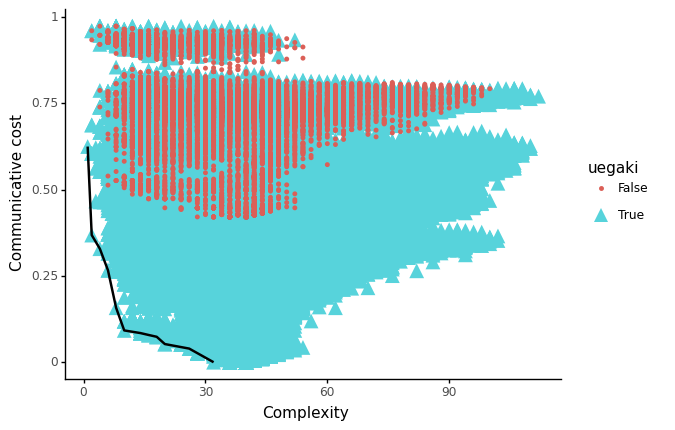

In [258]:
# smooth pareto curve again
pareto_df = pareto_data[["comm_cost", "complexity"]]
pareto_points = pareto_df.to_records(index=False).tolist()
# pareto_points = interpolate_data(pareto_points)
pareto_smoothed = pd.DataFrame(pareto_points, columns=["comm_cost", "complexity"])

# aesthetics for all data
# kwargs = {
#     "color": naturalness, #TODO: make uegaki the color, and counts the size
# }

kwargs = {}
kwargs["shape"] = "uegaki"
kwargs["size"] = "uegaki"
kwargs["color"] = "uegaki"

# if counts:
#     kwargs["size"] = "counts"

plot = (
    # Set data and the axes
    pn.ggplot(data=data, mapping=pn.aes(x="complexity", y="comm_cost"))
    # + pn.scale_y_continuous(limits=[0, 1])
    + pn.geom_point(  # all langs
        stroke=0,
        alpha=1,
        mapping=pn.aes(**kwargs),
    )
    + pn.geom_line(size=1, data=pareto_smoothed)
    + pn.xlab("Complexity")
    + pn.ylab("Communicative cost")
    # + pn.scale_color_cmap("cividis")
    + pn.theme_classic()
)
print(plot)

/Users/nathanielimel/miniforge3/envs/modals-effcomm/lib/python3.10/site-packages/plotnine/scales/scale_size.py:48: PlotnineWarning: Using size for a discrete variable is not advised.


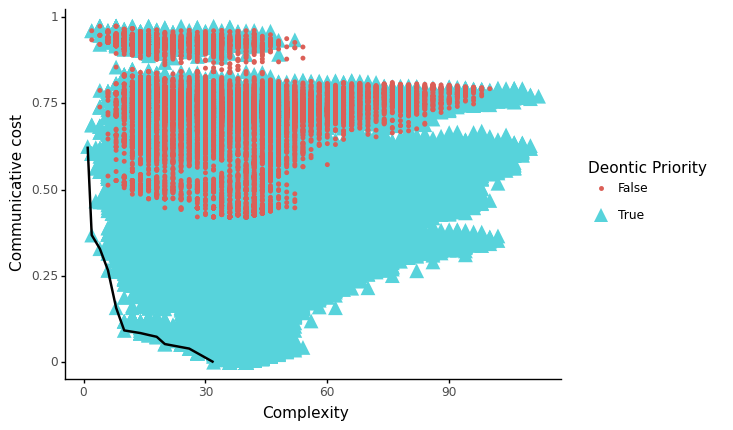

In [259]:
# redo plot with "Deontic Priority"

data["Deontic Priority"] = data["uegaki"]


kwargs = {}
kwargs["shape"] = "Deontic Priority"
kwargs["size"] = "Deontic Priority"
kwargs["color"] = "Deontic Priority"

# if counts:
#     kwargs["size"] = "counts"

plot = (
    # Set data and the axes
    pn.ggplot(data=data, mapping=pn.aes(x="complexity", y="comm_cost"))
    # + pn.scale_y_continuous(limits=[0, 1])
    + pn.geom_point(  # all langs
        stroke=0,
        alpha=1,
        mapping=pn.aes(**kwargs),
    )
    + pn.geom_line(size=1, data=pareto_smoothed)
    + pn.xlab("Complexity")
    + pn.ylab("Communicative cost")
    # + pn.scale_color_cmap("cividis")
    + pn.theme_classic()
)
print(plot)

In [260]:
# fn = "/Users/nathanielimel/clms/projects/modals-effcomm/outputs/cogsci/base/test/plot.png"
fn = f"/Users/nathanielimel/clms/projects/modals-effcomm/outputs/cogsci/base/{folder}/plot.png"
plot.save(filename=fn, width=10, height=10, dpi=300)

/Users/nathanielimel/miniforge3/envs/modals-effcomm/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 10 x 10 in image.
/Users/nathanielimel/miniforge3/envs/modals-effcomm/lib/python3.10/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /Users/nathanielimel/clms/projects/modals-effcomm/outputs/cogsci/base/weighted_prior_linear_search/ratio=16/plot.png
/Users/nathanielimel/miniforge3/envs/modals-effcomm/lib/python3.10/site-packages/plotnine/scales/scale_size.py:48: PlotnineWarning: Using size for a discrete variable is not advised.


## Statistics

### Means

In [261]:
# tradeoff properties
properties = ["complexity", "comm_cost", "optimality"]

uegaki_true = data[data["uegaki"] == True]
uegaki_false = data[data["uegaki"] == False]
uegaki_true_means = trade_off_means("uegaki_true", uegaki_true, properties)
uegaki_false_means = trade_off_means("uegaki_false", uegaki_false, properties)

population_means = trade_off_means("population_means", data, properties)

means_df = pd.concat([uegaki_true_means, uegaki_false_means, population_means]).set_index("name")
means_df

,complexity,comm_cost,optimality
name,,,
uegaki_true,41.309,0.481,0.770
uegaki_false,35.788,0.733,0.778
population_means,40.694,0.509,0.771


In [262]:
# get the sample sizes

means_df["N"] = [len(uegaki_true), len(uegaki_false), len(data)]
means_df
means_df.index = ["Deontic Priority true", "Deontic Priority false", "population"]
means_df

,complexity,comm_cost,optimality,N
Deontic Priority true,41.309,0.481,0.770,104074
Deontic Priority false,35.788,0.733,0.778,13039
population,40.694,0.509,0.771,117113


### T-test

In [263]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

pop_means_dict = population_means.iloc[0].to_dict()
ttest_uegaki_df = trade_off_ttest(uegaki_true, pop_means_dict, properties)
ttest_uegaki_df

,complexity,comm_cost,optimality
stat,,,
t-statistic,10.079,-52.423,-2.153
Two-sided p-value,0.000,0.000,0.031


In [264]:
# save dataframes
# means_fn = "/Users/nathanielimel/clms/projects/modals-effcomm/outputs/cogsci/base/test/means.csv"
# ttest_fn =  "/Users/nathanielimel/clms/projects/modals-effcomm/outputs/cogsci/base/test/ttest.csv"

means_fn = f"/Users/nathanielimel/clms/projects/modals-effcomm/outputs/cogsci/base/{folder}/means.csv"
ttest_fn =  f"/Users/nathanielimel/clms/projects/modals-effcomm/outputs/cogsci/base/{folder}/ttest.csv"

means_df.to_csv(means_fn)
ttest_uegaki_df.to_csv(ttest_fn)